In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from tensorflow import keras
import cv2
import pickle
from tensorflow.keras import backend as K
from PIL import Image
import matplotlib.patches as mpatches

# Load & Preprocessing

In [2]:
PATH = '/kaggle/input/bridge-cracks-image/DeepPCB/PCBData'

In [3]:
normal = []
defect = []
defectlog = []
path_2 = [os.path.join(PATH,dir) for dir in os.listdir(PATH) if '.' not in dir]
for p in tqdm(path_2,total=len(path_2)):
    path_3 = os.path.join(p,sorted(os.listdir(p))[0])
    normal +=[os.path.join(path_3,dir)for dir in os.listdir(path_3) if 'temp' in dir]
    defect +=[os.path.join(path_3,dir)for dir in os.listdir(path_3) if 'test' in dir]
    path_4 = os.path.join(p,sorted(os.listdir(p))[1])
    defectlog +=[os.path.join(path_4,dir)for dir in os.listdir(path_4)]
normal.sort()
defect.sort()
defectlog.sort()

  0%|          | 0/11 [00:00<?, ?it/s]

In [4]:
img0 = []
img1 = []
for img_path in tqdm(normal,total=len(normal)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(128,128))
    img0.append(img)
for img_path in tqdm(defect,total=len(defect)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(128,128))
    img1.append(img)
img0 = np.array(img0)
img1 = np.array(img1)
# with open(path+'img0.pkl', 'wb') as f:
#     pickle.dump(img0, f, pickle.HIGHEST_PROTOCOL)
# with open(path+'img1.pkl', 'wb') as f:
#     pickle.dump(img1, f, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/1501 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [5]:
# with open(path+'img0.pkl', 'rb') as f:
#     img0 = pickle.load(f)
# with open(path+'img1.pkl', 'rb') as f:
#     img1 = pickle.load(f)

In [6]:
box = []
i=0
for log in tqdm(defectlog,total=len(defectlog)):
    temp = pd.read_csv(log,sep=' ' ,names=['x1', 'y1', 'x2', 'y2', 'defect'], header=None).values.tolist()
    box.append(temp)
    i+=1
boxarr = []
for i in tqdm(range(len(box))):
    narr = np.zeros((640,640,1))
    for j in range(len(box[i])):
        x1,y1,x2,y2,d = box[i][j]
        narr = cv2.rectangle(narr,(x1,y1),(x2,y2),d,-1)
    narr = cv2.resize(narr,(88,88))
    boxarr.append(narr)
boxarr = np.array(boxarr)
# with open(path+'boxarr.pkl', 'wb') as f:
#     pickle.dump(boxarr, f, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [7]:
# with open(path+'boxarr.pkl', 'rb') as f:
#     boxarr = pickle.load(f)

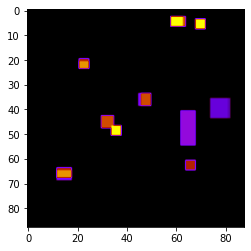

In [8]:
plt.imshow(np.reshape(boxarr[0],(88,88)),cmap='gnuplot')
plt.show()

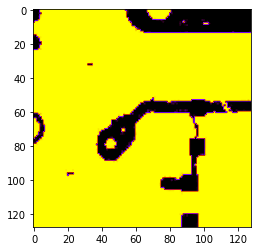

In [9]:
plt.imshow(np.reshape(img1[0],(128,128)),cmap='gnuplot')
plt.show()

# Make Dataset & UNet Model

We only use abnormal images for smooth segmentation.

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((img1,boxarr))

In [11]:
n=1500
dataset = dataset.shuffle(n)
train_dataset = dataset.take(int(n*0.8)).batch(100)
test_dataset = dataset.skip(int(n*0.8)).batch(100)

Originally, mirror padding was supposed to be used in Expanding Path, we simply use CenterCrop in Contracting Path

In [12]:
## layer5 cnn bn he flip
inputs = keras.layers.Input((128,128,1))
# x = keras.layers.experimental.preprocessing.Resizing(128,128)(inputs)
x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical')(x)

x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #126 126 64
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #124 124 64
x = keras.layers.Activation('relu')(x)
x1 = tf.identity(x)
x1 = keras.layers.experimental.preprocessing.CenterCrop(92,92)(x1)

x = keras.layers.MaxPooling2D((2, 2), strides=2)(x) #62 62,64

x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #60 60 128
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #58 58 128
x = keras.layers.Activation('relu')(x)
x2 = tf.identity(x)
x2 = keras.layers.experimental.preprocessing.CenterCrop(50,50)(x2)

x = keras.layers.MaxPooling2D((2, 2), strides=2)(x) #29 29 128

x = keras.layers.Conv2D(filters=256,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #27 27 256
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=256,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #25 25 256
x = keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2, strides=(2, 2),kernel_initializer=tf.keras.initializers.HeNormal())(x) # 50 50 128

x = keras.layers.Concatenate()([x,x2]) #50 50 256
x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #48 48 128
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #46 46 128
x = keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2, strides=(2, 2),kernel_initializer=tf.keras.initializers.HeNormal())(x) # 92 92 64

x = keras.layers.Concatenate()([x,x1]) #92,92 128
x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #90 90 64
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #88 88 64
x = keras.layers.Activation('relu')(x)

outputs = keras.layers.Conv2D(filters=7,kernel_size=1,kernel_initializer=tf.keras.initializers.HeNormal())(x) #88 88 7

In [13]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 128, 128, 1)  0           rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 64) 640         random_flip[0][0]                
______________________________________________________________________________________________

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

In [15]:
# callback = tf.keras.callbacks.ModelCheckpoint(PATH+'model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='loss', save_freq='epoch',)
# history = model.fit(train_dataset,epochs=1000,validation_data=test_dataset,callbacks=[callback])
history = model.fit(train_dataset,epochs=500,validation_data=test_dataset,verbose=0)

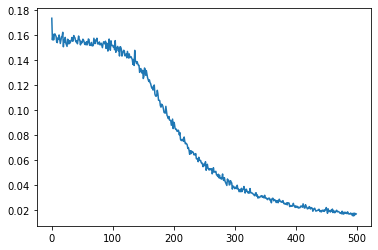

In [16]:
plt.plot(history.history['val_loss'])
plt.show()

# Plot Predict

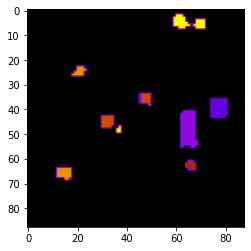

In [17]:
out = model.predict(tf.reshape(img1[0],(-1,128,128,1)))
out2 = np.argmax(out,axis=3)
plt.imshow(out2[0],cmap='gnuplot')

In [18]:
img_arr_resized = cv2.resize(img1[0],(88,88))
img_arr_resized = cv2.cvtColor(img_arr_resized,cv2.COLOR_GRAY2RGB)

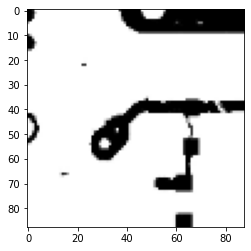

In [19]:
plt.imshow(img_arr_resized)

# Result Visualization

In [20]:
pred = model.predict(tf.reshape(img1[0],(-1,128,128,1)))
pred = np.argmax(pred,axis=3)[0]

In [21]:
new_pred = np.zeros((88,88,3),dtype=np.uint8)

In [22]:
new_pred[pred==0] = img_arr_resized[pred==0]
new_pred[pred==1] = [255,228,0] #open
new_pred[pred==2] = [1,0,255] #short
new_pred[pred==3] = [29,219,22] #mousebite
new_pred[pred==4] = [255,0,0] #spur
new_pred[pred==5] = [103,0,0] #copper
new_pred[pred==6] = [255,0,127] #pin-hole

In [23]:
blend_img1=Image.fromarray(img_arr_resized)
blend_img2=Image.fromarray(new_pred)
blend_img=Image.blend(blend_img1,blend_img2,0.5)

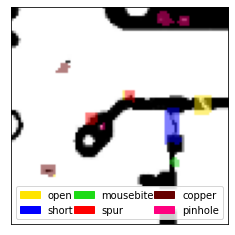

In [24]:
legend1 = mpatches.Patch(color='#FFE400', label='open')
legend2 = mpatches.Patch(color='#0100FF', label='short')
legend3 = mpatches.Patch(color='#1DDB16', label='mousebite')
legend4 = mpatches.Patch(color='#FF0000', label='spur')
legend5 = mpatches.Patch(color='#670000', label='copper')
legend6 = mpatches.Patch(color='#FF007F', label='pinhole')
plt.legend(loc='lower left', handles=[legend1,legend2,legend3,legend4,legend5,legend6],mode = "expand", ncol = 3,fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(np.array(blend_img))
plt.show()

# Transfer Learning : Find the exact number of errors for each type

Make DataSet and Preprocessing

In [25]:
log_df = pd.DataFrame(columns=['0','1','2','3','4','5','6'])
i=0
for log in tqdm(defectlog,total=len(defectlog)):
    temp_df = pd.read_csv(log,sep=' ' ,names=['x1', 'y1', 'x2', 'y2', 'defect'], header=None)
    temp = np.zeros(7,dtype=int)
    for t in temp_df['defect']:
        temp[t]+=1
    log_df.loc[i,:] = temp
    i+=1

  0%|          | 0/1500 [00:00<?, ?it/s]

In [26]:
dataset2 = tf.data.Dataset.from_tensor_slices((img1,log_df.values.astype(np.int)))

In [27]:
n=1500
dataset2 = dataset2.shuffle(n)
train_dataset2 = dataset2.take(int(n*0.8)).batch(100)
test_dataset2 = dataset2.skip(int(n*0.8)).batch(100)

Use pretrained Unet Contracting Path

In [28]:
load_model = tf.keras.models.Model(
    [model.inputs],
    [model.layers[16].output]
)

In [29]:
for layer in load_model.layers:
    layer.trainable=False

Add Classification Model to Unet Contracting Path

In [30]:
x = load_model.output #25 25 256
x = keras.layers.MaxPooling2D((3, 3), strides=2)(x) #12 12 256
x_l = keras.layers.BatchNormalization()(x)
x_l = keras.layers.Activation('relu')(x_l)
x_l = keras.layers.Conv2D(filters=256,kernel_size=1,padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(x_l)
x_l = keras.layers.BatchNormalization()(x_l)
x_l = keras.layers.Activation('relu')(x_l)
x_l = keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(x_l)
x = keras.layers.Concatenate()([x, x_l]) #12 12 320

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=160,kernel_size=1,padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(x)
x = keras.layers.MaxPooling2D((2, 2), strides=2)(x) #6 6 160

x_l = keras.layers.BatchNormalization()(x)
x_l = keras.layers.Activation('relu')(x_l)
x_l = keras.layers.Conv2D(filters=160,kernel_size=1,padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(x_l)
x_l = keras.layers.BatchNormalization()(x_l)
x_l = keras.layers.Activation('relu')(x_l)
x_l = keras.layers.Conv2D(filters=40,kernel_size=3,padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(x_l)
x = keras.layers.Concatenate()([x, x_l]) #6 6 200

x = keras.layers.GlobalAveragePooling2D()(x) #1*1*200
outputs = keras.layers.Dense(7,activation='linear')(x)

In [31]:
model2 = keras.Model(load_model.inputs, outputs)
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 128, 128, 1)  0           rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 64) 640         random_flip[0][0]                
____________________________________________________________________________________________

In [32]:
model2.compile(
    optimizer='adam',
    loss='mse'
)

In [33]:
# callback2 = tf.keras.callbacks.ModelCheckpoint(path+'model2.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='loss', save_freq='epoch',)
# history2 = model2.fit(train_dataset2,epochs=1000,validation_data=test_dataset2,callbacks=[callback2])
history2 = model2.fit(train_dataset2,epochs=500,validation_data=test_dataset2,verbose=0)

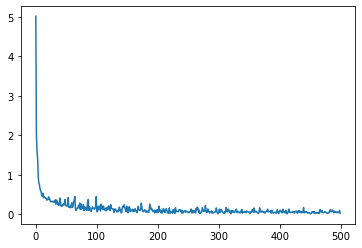

In [34]:
plt.plot(history2.history['val_loss'])
plt.show()

In [35]:
model2_pred = model2.predict(tf.reshape(img1[-1],(-1,128,128,1)))
model2_pred

array([[-0.05392965,  0.9782469 ,  1.2899321 , -0.02730501,  2.0275826 ,
         0.97793245,  0.88574326]], dtype=float32)

In [36]:
np.round(model2_pred).astype(np.int)

array([[0, 1, 1, 0, 2, 1, 1]])

In [37]:
log_df.values[-1]

array([0, 1, 1, 0, 2, 1, 1], dtype=object)

model got the right answer.

if you saved best model by using callback and use that, the result will be more accurate.